In [3]:
import torch
import torch.nn as nn
from transformers import ViTModel, BertModel

class CrossAttentionBlock(nn.Module):
    def __init__(self, dim_q, dim_kv, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim_q, kdim=dim_kv, vdim=dim_kv, num_heads=num_heads, batch_first=True)
    
    def forward(self, query, key_value):
        out, _ = self.attn(query, key_value, key_value)
        return out

class MemeCrossAttentionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.cross_attn_img_to_txt = CrossAttentionBlock(dim_q=768, dim_kv=768)
        self.cross_attn_txt_to_img = CrossAttentionBlock(dim_q=768, dim_kv=768)

        self.classifier_input_dim = 768 * 2 
        self.sentiment_classifier = nn.Sequential(
            nn.Linear(self.classifier_input_dim, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)  # Output: 3 sentiment classes
        )
        
        self.humor_classifier = nn.Sequential(
            nn.Linear(self.classifier_input_dim, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)  # Output: 4 humor classes
        )
        
        self.sarcasm_classifier = nn.Sequential(
            nn.Linear(self.classifier_input_dim, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)  # Output: 4 sarcasm classes
        )
        
        self.offense_classifier = nn.Sequential(
            nn.Linear(self.classifier_input_dim, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)  # Output: 4 offense classes
        )

    def forward(self, image, text):
        vit_out = self.vit(pixel_values=image).last_hidden_state      
        bert_out = self.bert(**text).last_hidden_state                

        img_cls = vit_out[:, 0:1, :]      
        text_cls = bert_out[:, 0:1, :]    

        img_attn = self.cross_attn_img_to_txt(img_cls, bert_out)  
        text_attn = self.cross_attn_txt_to_img(text_cls, vit_out)  

        combined = torch.cat([img_attn.squeeze(1), text_attn.squeeze(1)], dim=-1)  

        return {
            'sentiment_logits': self.sentiment_classifier(combined),
            'humor_logits': self.humor_classifier(combined),
            'sarcasm_logits': self.sarcasm_classifier(combined),
            'offense_logits': self.offense_classifier(combined),
        }


In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [5]:
model = MemeCrossAttentionClassifier()
model.load_state_dict(torch.load("/Users/sahilpandey/Projects/Sentiment_Analysis/models/meme_classifier_final.pth", map_location=device))
model.to(device)
model.eval()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MemeCrossAttentionClassifier(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inter

In [6]:
import easyocr
from transformers import BertTokenizer, ViTFeatureExtractor
from PIL import Image
import torchvision.transforms as transforms
import torch

In [7]:
reader = easyocr.Reader(['en'])  # OCR reader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = MemeCrossAttentionClassifier()
model.load_state_dict(torch.load("/Users/sahilpandey/Projects/Sentiment_Analysis/models/meme_classifier_final.pth", map_location=device))
model.to(device)
model.eval()

/Users/sahilpandey/miniconda3/envs/gdg/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MemeCrossAttentionClassifier(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inter

In [11]:
import numpy as np

def predict_meme_labels(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")

    # OCR Text (convert to NumPy array)
    image_np = np.array(image)
    text_output = reader.readtext(image_np, detail=0)
    text = " ".join(text_output)

    # Text Encoding
    encoded_text = tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors='pt')
    encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

    # Image Preprocessing for ViT
    vit_input = feature_extractor(images=image, return_tensors="pt")["pixel_values"].to(device)

    # Inference
    with torch.no_grad():
        output = model(vit_input, encoded_text)

    preds = {
        "sentiment": torch.argmax(output["sentiment_logits"], dim=1).item(),
        "humor": torch.argmax(output["humor_logits"], dim=1).item(),
        "sarcasm": torch.argmax(output["sarcasm_logits"], dim=1).item(),
        "offense": torch.argmax(output["offense_logits"], dim=1).item(),
        "text": text
    }

    return preds

/Users/sahilpandey/miniconda3/envs/gdg/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


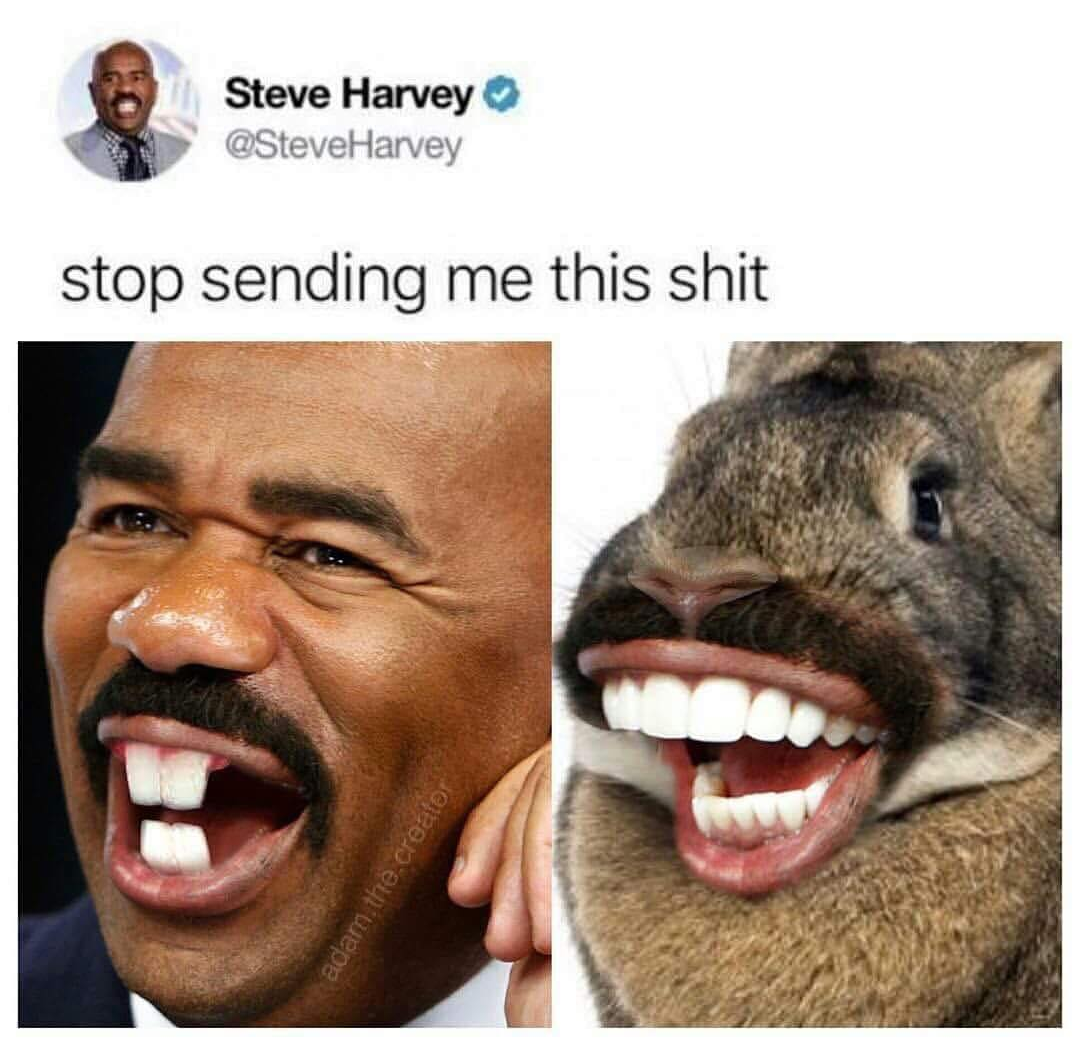

🧠 Model Predictions:
Sentiment: positive
Humor: very_funny
Sarcasm: general
Offensiveness: slight
OCR Text: Steve Harvey @SteveHarvey stop sending me this shit 8 2 8


In [15]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
# === Your mapping dictionaries ===
humor_map = {0: "not_funny", 1: "funny", 2: "very_funny", 3: "hilarious"}
sarcasm_map = {0: "not_sarcastic", 1: "general", 2: "twisted_meaning", 3: "very_twisted"}
offense_map = {0: "not_offensive", 1: "slight", 2: "very_offensive", 3: "hateful_offensive"}
sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}

# === Image path ===
image_path = "/Users/sahilpandey/Projects/Sentiment_Analysis/steve.png"

# === Run inference ===
result = predict_meme_labels(image_path)

# === Show image ===
image = Image.open(image_path).convert("RGB")
display(image)

# === Print nicely mapped results ===
print("🧠 Model Predictions:")
print(f"Sentiment: {sentiment_map[result['sentiment']]}")
print(f"Humor: {humor_map[result['humor']]}")
print(f"Sarcasm: {sarcasm_map[result['sarcasm']]}")
print(f"Offensiveness: {offense_map[result['offense']]}")
print(f"OCR Text: {result['text']}")